In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn import cross_validation, metrics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [59]:
def fit_clf(clf, X_train, y_train):
    #clf = XGBClassifier(max_depth=40, base_score=0.006)
    #clf = XGBClassifier(booster='dart', max_depth=16, learning_rate=0.1, objective='binary:logistic', silent=True, sample_type='uniform',
    #                normalize_type='tree', rate_drop=0.1, skip_drop=0.1, base_score=0.006);
    
    cv = StratifiedKFold(y_train, n_folds=5, shuffle=True)
    y_pred_train = np.ones(y_train.shape[0])
    for i, (train, test) in enumerate(cv):
        y_pred_train[test] = clf.fit(X_train.iloc[train], y_train.iloc[train]).predict_proba(X_train.iloc[test])[:,1]
        print("fold {}, ROC AUC: {:.3f}".format(i, metrics.roc_auc_score(y_train.iloc[test], y_pred_train[test])))
    print(metrics.roc_auc_score(y_train, y_pred_train))

    clf.fit(X_train, y_train)
    y_pred_train = clf.predict_proba(X_train)[:,1]
    plt.figure()
    thresholds = np.linspace(0.01, 1.00, 100)
    mcc = np.array([metrics.matthews_corrcoef(y_train, y_pred_train>thr) for thr in thresholds])
    plt.plot(thresholds, mcc)
    best_threshold = thresholds[mcc.argmax()]
    print("MCC: %f" % mcc.max())
    
    return clf, best_threshold


In [3]:
X = pd.read_csv("X_20180624_2.csv", index_col=0)


C:\Users\tmiya\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [17]:
y = pd.read_csv("../input/train_numeric.csv", index_col=0, usecols=[0,969])

C:\Users\tmiya\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [18]:
(y == 1).sum()

Response    6879
dtype: int64

In [5]:
(y == 0).sum()

0    1176867
dtype: int64

In [63]:
X_fai = X[y['Response']==1]
y_fai = y[y['Response']==1]

In [62]:
X_suc = X[y['Response']==0]
y_suc = y[y['Response']==0]

fold 0, ROC AUC: 0.643
fold 1, ROC AUC: 0.750
fold 2, ROC AUC: 0.604
fold 3, ROC AUC: 0.573
fold 4, ROC AUC: 0.707
0.6560977951647933


C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.734844


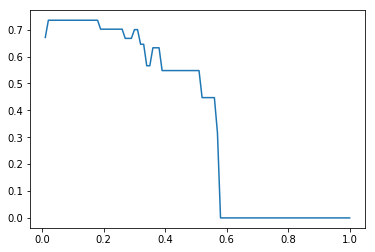

In [65]:
clf = XGBClassifier(max_depth=5, base_score=0.0001)
[clf, best_threshold] = fit_clf(clf, pd.concat([X_suc, X_fai[0:10]]), pd.concat([y_suc, y_fai[0:10]])['Response'])